Εγκατάσταση και προετοιμασία

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Ρύθμιση συσκευής (GPU αν είναι διαθέσιμη)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Μετασχηματισμοί για τη βάση δεδομένων (Κανονικοποίηση)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Φόρτωση CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 90
train_loader = DataLoader(train_dataset, batch_size, shuffle=True) #Ανακάτεμα των δειγμάτων πριν δημιουργηθούν σε batches
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Ορισμός του MLP

In [10]:
class MLP(nn.Module):  # Δήλωση της κλάσης που θα υλοποιεί το MLP
    def __init__(self):
        super(MLP, self).__init__()  # Ο constructor ορίζει τα στρώματα (layers) και τις παραμέτρους του μοντέλου.
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)  # Είσοδος (32x32x3)
        self.fc2 = nn.Linear(1024, 512)         # 1o Κρυφό επίπεδο
        self.fc3 = nn.Linear(512, 256)         # 2o Κρυφό επίπεδο
        self.fc4 = nn.Linear(256,128)          # 3ο κρυφό επίπεδο
        self.fc5 = nn.Linear(128,10)           # Έξοδος (10 κλάσεις)
        self.dropout = nn.Dropout(0.4)         # Dropout για γενίκευση

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Μετατροπή σε μονοδιάστατο διάνυσμα
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x= torch.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

# Δημιουργία του μοντέλου
model = MLP().to(device)

Απώλεια και βελτιστοποίηση

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004, weight_decay=0.000001)

Συνάρτηση αξιολόγησης

In [12]:
# Συνάρτηση αξιολόγησης
def evaluate_model(model, data_loader):
    model.eval()  # Θέτουμε το μοντέλο σε κατάσταση αξιολόγησης
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []



    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Συλλογή προβλέψεων και πραγματικών ετικετών
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Υπολογισμός metrics
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return accuracy, precision, recall, f1

Εκπαίδευση του μοντέλου

In [14]:
# Εκπαίδευση του μοντέλου
num_epochs = 30
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
best_test_accuracy = 0
patience = 5
epochs_without_improvement = 0


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Αξιολόγηση
    model.eval()
    test_loss = 0.0
    with torch.no_grad():  # Απενεργοποιείται ο υπολογισμός των gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))

    # Υπολογισμός metrics για train και test
    train_acc, train_prec, train_recall, train_f1 = evaluate_model(model, train_loader)
    test_acc, test_prec, test_recall, test_f1 = evaluate_model(model, test_loader)

    # Αποθήκευση του καλύτερου test accuracy
    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1



    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train - Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {train_acc:.2f}%, Precision: {train_prec:.2f}, Recall: {train_recall:.2f}, F1: {train_f1:.2f}")
    print(f"Test  - Loss: {test_loss/len(test_loader):.4f}, "
          f"Accuracy: {test_acc:.2f}%, Precision: {test_prec:.2f}, Recall: {test_recall:.2f}, F1: {test_f1:.2f}")

    # Έλεγχος για βελτιστοποίηση
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Τελική αξιολόγηση στο Training και Test set
final_train_acc, final_train_prec, final_train_recall, final_train_f1 = evaluate_model(model, train_loader)
final_test_acc, final_test_prec, final_test_recall, final_test_f1 = evaluate_model(model, test_loader)

print("\nFinal Evaluation:")
print(f"Training Set - Accuracy: {final_train_acc:.2f}%, Precision: {final_train_prec:.2f}, Recall: {final_train_recall:.2f}, F1: {final_train_f1:.2f}")
print(f"Test Set     - Accuracy: {final_test_acc:.2f}%, Precision: {final_test_prec:.2f}, Recall: {final_test_recall:.2f}, F1: {final_test_f1:.2f}")

Epoch [1/30]
Train - Loss: 1.8375, Accuracy: 43.16%, Precision: 0.44, Recall: 0.43, F1: 0.42
Test  - Loss: 1.6208, Accuracy: 43.29%, Precision: 0.44, Recall: 0.43, F1: 0.43
Epoch [2/30]
Train - Loss: 1.6608, Accuracy: 47.79%, Precision: 0.47, Recall: 0.48, F1: 0.47
Test  - Loss: 1.5077, Accuracy: 47.19%, Precision: 0.47, Recall: 0.47, F1: 0.46
Epoch [3/30]
Train - Loss: 1.5803, Accuracy: 50.80%, Precision: 0.51, Recall: 0.51, F1: 0.50
Test  - Loss: 1.4717, Accuracy: 48.50%, Precision: 0.49, Recall: 0.48, F1: 0.48
Epoch [4/30]
Train - Loss: 1.5196, Accuracy: 53.11%, Precision: 0.53, Recall: 0.53, F1: 0.53
Test  - Loss: 1.4263, Accuracy: 49.94%, Precision: 0.50, Recall: 0.50, F1: 0.50
Epoch [5/30]
Train - Loss: 1.4697, Accuracy: 54.14%, Precision: 0.54, Recall: 0.54, F1: 0.54
Test  - Loss: 1.3925, Accuracy: 51.72%, Precision: 0.52, Recall: 0.52, F1: 0.51
Epoch [6/30]
Train - Loss: 1.4277, Accuracy: 56.06%, Precision: 0.56, Recall: 0.56, F1: 0.56
Test  - Loss: 1.3781, Accuracy: 51.64%, Pr

Οπτικοποίηση αποτελεσμάτων

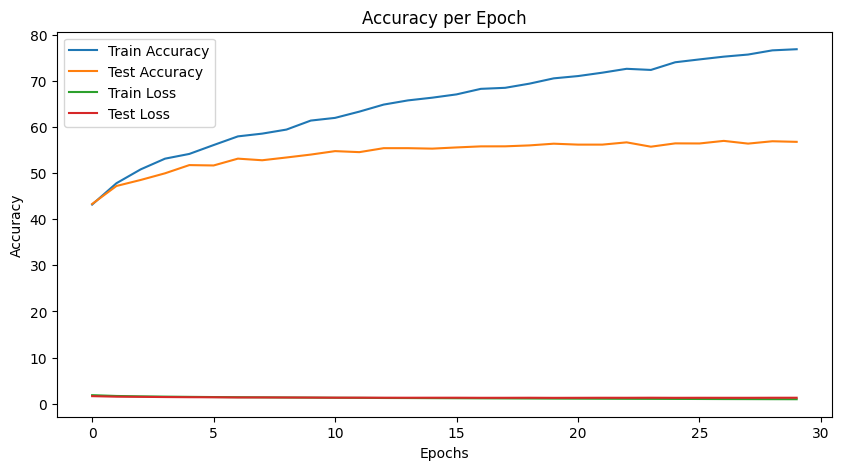

In [15]:
# Οπτικοποίηση των αποτελεσμάτων
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()